In [2]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'


In [4]:
#import convert_sets 
# ^ run script to make datasets if they aren't already made!

In [5]:
#load up data
pipm_med = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
pi0_med = np.load('/fast_scratch/atlas_images/v01-45/pi0_medium.npz')

In [6]:
#extract data
X_pipm = pipm_med['X']
X_pi0 = pi0_med['X']

Y_label_pipm = pipm_med['Y_label']
Y_label_pi0 = pi0_med['Y_label']

clus_eta_pipm = pipm_med['clus_eta']
clus_eta_pi0 = pi0_med['clus_eta']

In [7]:
#select size of datasets
X_all = np.concatenate((X_pipm[:390000], X_pi0[:390000]))
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:390000],Y_label_pi0[:390000])))
eta = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))
X_glob = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))

In [8]:
def modelNmetrics_complete(X_cell, X_glob, Y, eta, epochs, batch_size, val_size, test_size):
    #one function to run the model & create the metrics
    
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X_cell), 'Y: ', len(Y), 'test:', test_size)
    
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, eta_train, eta_val, eta_test) = data_split(X_cell, Y, X_glob, eta, val=val_size, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    
    #concatenate the Xs (needed for global features):
    X_tr = [X_train, X_glob_tr]
    X_vali = [X_val, X_glob_val]
    X_te = [X_test, X_glob_te]
    
    #make the model:
    pfn = PFN(input_dim=X_cell.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn4.hdf5', save_best_only=True)
    
    # train model
    history = pfn.fit(X_tr, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_vali, Y_val), verbose=1, callbacks=[callback])
    
    #define the different eta regions
    selec_l07 = abs(eta_test) < 0.7
    selec_b0714 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.4)
    selec_b1425 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 2.5)
    selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1) #max eta is 3 so!!
    selec_all = abs(eta_test) <= 3.1 
    
    selections = [selec_l07, selec_b0714, selec_b1425, selec_b2531, selec_all]
    
    #make metrics; test model for each of the different ranges of eta
    X_1, X_2 = X_te
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in selections:
        X_interm = [X_1[selection], X_2[selection]] #YAY got it working!! just had to split it up to make the selection
        preds = pfn.predict(X_interm, batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
   
    return history, fps, tps, aucs, selections

In [9]:
def plots_complete(history, fp_all, tp_all, auc_all):
    #function to plot acc/loss and roc curves nicely
    labs = ['$\eta$ < .7', '.7 < $\eta$ < 1.4', '1.4 < $\eta$ < 2.5', '2.5 < $\eta$ < 3.1', 'all $\eta$']
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,len(history.history['acc']))
    ax1.plot(history.history['acc'], label='training set', c='xkcd:greyish brown', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:toupe', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,len(history.history['acc']))
    ax2.plot(history.history['loss'], label='training set', c='xkcd:raw sienna', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:very light brown', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()
    
    fig2, (ax3, ax4) = plt.subplots(1,2, figsize=[12,6])
    
    ax3.set_xlim(-.01,1.01)
    ax3.set_ylim(-.01,1.01)
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.plot(fp_all[0], tp_all[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%auc_all[0])
    ax3.plot(fp_all[1], tp_all[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%auc_all[1])
    ax3.plot(fp_all[2], tp_all[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%auc_all[2])
    ax3.plot(fp_all[3], tp_all[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%auc_all[3])
    ax3.plot(fp_all[4], tp_all[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%auc_all[4])
    ax3.set_ylabel('True positive rate')
    ax3.set_xlabel('False positive rate')
    ax3.legend() 
    
    ax4.set_xlim(-.01,.4)
    ax4.set_ylim(.6,1.01)
    ax4.plot([0, 1], [0, 1], 'k--')
    ax4.plot(fp_all[0], tp_all[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%auc_all[0])
    ax4.plot(fp_all[1], tp_all[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%auc_all[1])
    ax4.plot(fp_all[2], tp_all[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%auc_all[2])
    ax4.plot(fp_all[3], tp_all[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%auc_all[3])
    ax4.plot(fp_all[4], tp_all[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%auc_all[4])
    ax4.set_ylabel('True positive rate')
    ax4.set_xlabel('False positive rate')
    ax4.legend() 

In [10]:
#examine aucs by loading up old model (produced in Week6_part1 notebook at the bottom) - have to fit this into the actual function
model = tf.keras.models.load_model('./w6_pfn4')

In [15]:
#rerun in order to examine 'best' model (this was produced in a different notebook)
(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, eta_train, eta_val, eta_test) = data_split(X_all, Y_all, X_glob, eta, val=100000, test=100000)

In [12]:
#concatenate the Xs:
X_tr = [X_train, X_glob_tr]
X_vali = [X_val, X_glob_val]
X_te = [X_test, X_glob_te]

#define the different eta regions
selec_l07 = abs(eta_test) < 0.7
selec_b0714 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.4)
selec_b1425 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 2.5)
selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1)
selec_all = abs(eta_test) <= 3.1 

selections = [selec_l07, selec_b0714, selec_b1425, selec_b2531, selec_all]

#make metrics
X_1, X_2 = X_te
fps = []
tps = []
threshss = []
aucs = []
for selection in selections:
    X_interm = [X_1[selection], X_2[selection]]
    preds = model.predict(X_interm, batch_size=1000) 
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])

    fps.append(pfn_fp)
    tps.append(pfn_tp)
    threshss.append(threshs)

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
    aucs.append(auc)
    print('PFN AUC:', auc)


PFN AUC: 0.9818945603469429
PFN AUC: 0.9782994540338844
PFN AUC: 0.9481091157368675
PFN AUC: 0.9861235707954426
PFN AUC: 0.969757888427691


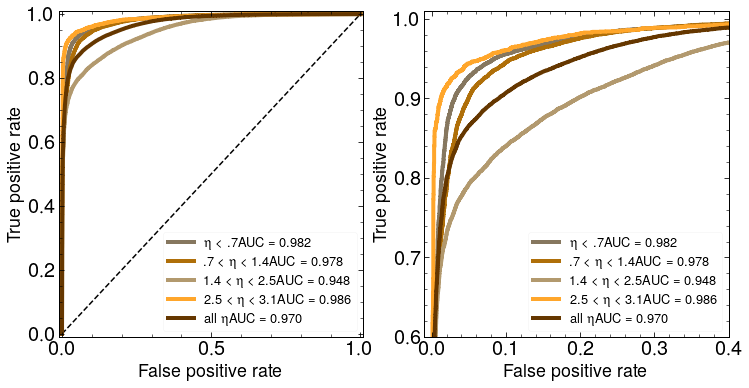

In [14]:
#just want to plot the roc curves of the 'best' version of the old model
labs = ['$\eta$ < .7', '.7 < $\eta$ < 1.4', '1.4 < $\eta$ < 2.5', '2.5 < $\eta$ < 3.1', 'all $\eta$']
 
fig2, (ax3, ax4) = plt.subplots(1,2, figsize=[12,6])
    
ax3.set_xlim(-.01,1.01)
ax3.set_ylim(-.01,1.01)
ax3.plot([0, 1], [0, 1], 'k--')
ax3.plot(fps[0], tps[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%aucs[0])
ax3.plot(fps[1], tps[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%aucs[1])
ax3.plot(fps[2], tps[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%aucs[2])
ax3.plot(fps[3], tps[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%aucs[3])
ax3.plot(fps[4], tps[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%aucs[4])
ax3.set_ylabel('True positive rate')
ax3.set_xlabel('False positive rate')
ax3.legend() 

ax4.set_xlim(-.01,.4)
ax4.set_ylim(.6,1.01)
ax4.plot([0, 1], [0, 1], 'k--')
ax4.plot(fps[0], tps[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%aucs[0])
ax4.plot(fps[1], tps[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%aucs[1])
ax4.plot(fps[2], tps[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%aucs[2])
ax4.plot(fps[3], tps[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%aucs[3])
ax4.plot(fps[4], tps[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%aucs[4])
ax4.set_ylabel('True positive rate')
ax4.set_xlabel('False positive rate')
ax4.legend() 

In [12]:
#this is a model WITHOUT the global features!! run this, then compare to the one WITH global features. See if including it helps!
def modelNmetrics_noglob(X_cell, Y, eta, epochs, batch_size, val_size, test_size):
    #run the model & create the metrics
    
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X_cell), 'Y: ', len(Y), 'test:', test_size)
    
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test, eta_train, eta_val, eta_test) = data_split(X_cell, Y, eta, val=val_size, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    
    #make the model:
    pfn = PFN(input_dim=X_cell.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)#, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn4.hdf5', save_best_only=True)
    
    # train model
    history = pfn.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, callbacks=[callback])
    
    #define the different eta regions
    selec_l07 = abs(eta_test) < 0.7
    selec_b0714 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.4)
    selec_b1425 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 2.5)
    selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1) #max eta is 3 so!!
    selec_all = abs(eta_test) <= 3.1 
    
    selections = [selec_l07, selec_b0714, selec_b1425, selec_b2531, selec_all]
    
    #load up best model
    best = tf.keras.models.load_model('./w6_pfn4')
    
    #make metrics
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in selections:
        preds = best.predict(X_test[selection], batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
   
    return history, fps, tps, aucs, selections

In [ ]:
history_nog, fp_nog, tp_nog, auc_nog, selecs_nog = modelNmetrics_noglob(X_all, Y_all, eta, 200, 1000, 100000, 100000)

sizes: X  780000 Y:  780000 test: 100000
(580000, 2000, 4) (100000, 2000, 4) (100000, 2000, 4) (580000, 2) (100000, 2) (100000, 2)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100  